In [10]:
library(bbmle)
library(tidyverse)
library(tidyr)
library(deSolve)
library(plyr)
options(repr.plot.width = 8, repr.plot.height =5.5)
dev.new(width=8, height=4.5)
set.seed(1234)

## SIR model
We first decide what model to use. Using S,I,R to represent proportions we use: 

$\frac{dX}{dt} = -\frac{\beta{X}{Y}}{N}$

$\frac{dY}{dt} = \frac{\beta{X}{Y}}{N} - \gamma{Y}$

$\frac{dZ}{dt} = \gamma{Y}$

In [51]:
model <- function(beta, gamma, initial_conditions, times){
    equations <- function(time, variables, parameters) {
        with(as.list(c(variables, parameters)), {
            N <- X+Y+Z
            dX <- -beta * X * Y/N
            dY <- beta * X*Y/N - gamma * Y
            dZ <-  gamma * Y
            return(list(c(dX, dY, dZ)))
        })
    }
    out <- ode(
        y = initial_conditions,
        times = times,
        func = equations,
        parms = c(beta=beta, gamma=gamma) 
    )
    as.data.frame(out)
}

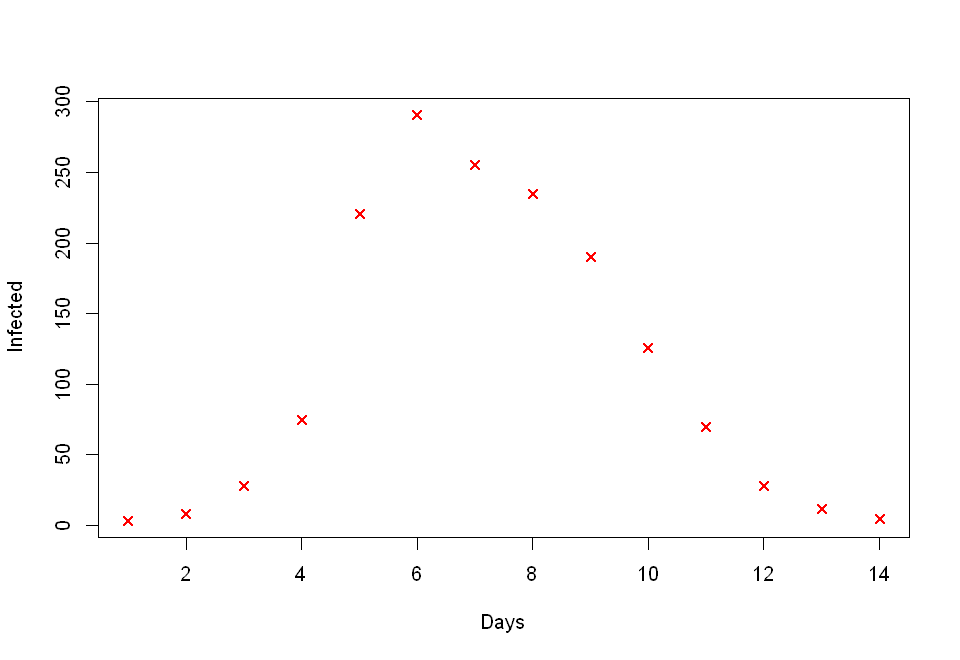

In [52]:
df <- data.frame(read.csv('BoardingSchoolFlu.csv', header=TRUE))
N = 763
initial_conditions <- c(X=(N-df$cases[1]), Y=df$cases[1], Z=0)
plot(df$days, df$cases, xlab='Days', ylab='Infected', col='red', pch=4, lwd=1.6)

In [95]:
compare_model <- function(predicted, title, times){
    plot(df$days, df$cases, xlab='Days', ylab='Cases', col='red', lwd=1.6, pch=4)
    legend(1, 250, legend=c("Predicted", "Actual"),
           col=c("red", "grey"), lty=1:5, y.intersp=2)
    
    lines(loess(predicted~times), col='black', lty=5)
    title(title)
}

## Using Least Squares
We can use Least Squares to estimate our parameters, and then in further approaches use these parameters as our initial conditions.

In [125]:
ss <- function(params) {
  I0 <- df$cases[1]
  times <- df$days
  predictions <- model(beta = params[1], gamma = params[2], initial_conditions,times = df$days)
  sum((predictions$Y[-1] - df$cases[-1])^2)
}

In [130]:
starting_param_val <- c(1, 1)
ss_optim <- optim(starting_param_val, ss)
parameters_ss <- c(beta=ss_optim$par[1], gamma=ss_optim$par[2])
ss_optim$value

[1] 3923.881

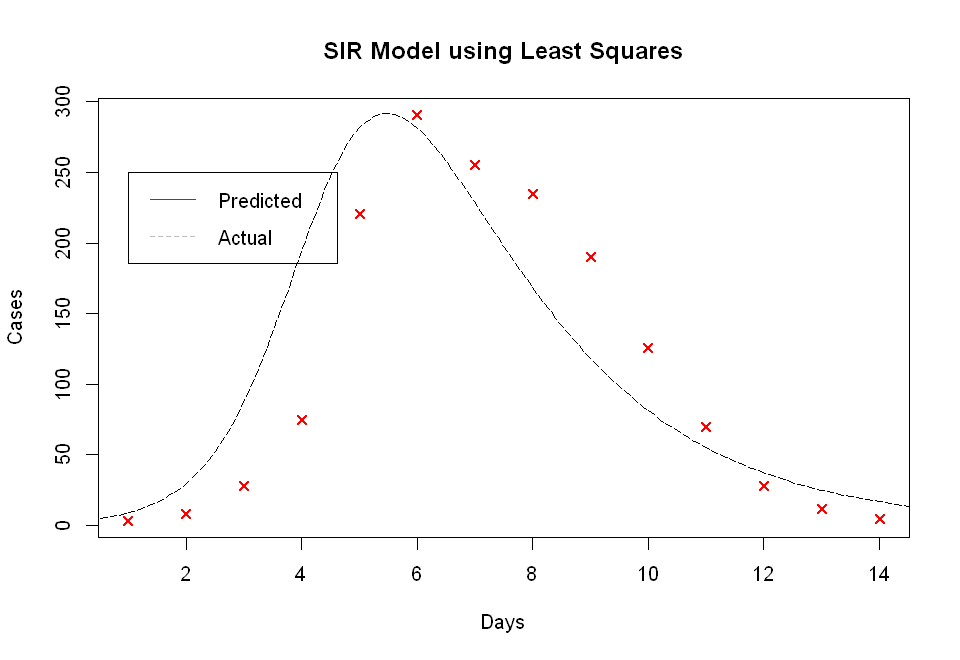

In [131]:
times <- seq(0,20,0.1)
normal_model <-c(as.double(initial_conditions['Y']), model(gamma=as.double(parameters_ss['gamma']),
                       beta=as.double(parameters_ss['beta']),
                       times = seq(0.1,20,0.1),
                       initial_conditions=initial_conditions)$Y)
compare_model(normal_model, "SIR Model using Least Squares", times)

## Using Normal MLE 
Now we have our initial parameter guesses in `parameters_ss`. We have our likelihood function, what happens if we just vary our standard deviation?

In [132]:
normalLL <- function(gamma, beta,sigma){
    gamma <- exp(gamma)
    beta <- exp(beta)
    sigma <- exp(sigma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_conditions=initial_conditions)$X[-1]
    -sum(dnorm(x=df$cases[-1],mean=model_data, sd=sigma, log=TRUE))
}
res <- c()
standard_dev <- seq(1, 20, 0.05)
lapply(standard_dev, function(sigma){
    append(res, normalLL(as.double(parameters_ss['gamma']), as.double(parameters_ss['beta'], sigma)))
})
res

ERROR: Error in normalLL(as.double(parameters_ss["gamma"]), as.double(parameters_ss["beta"], : argument "sigma" is missing, with no default


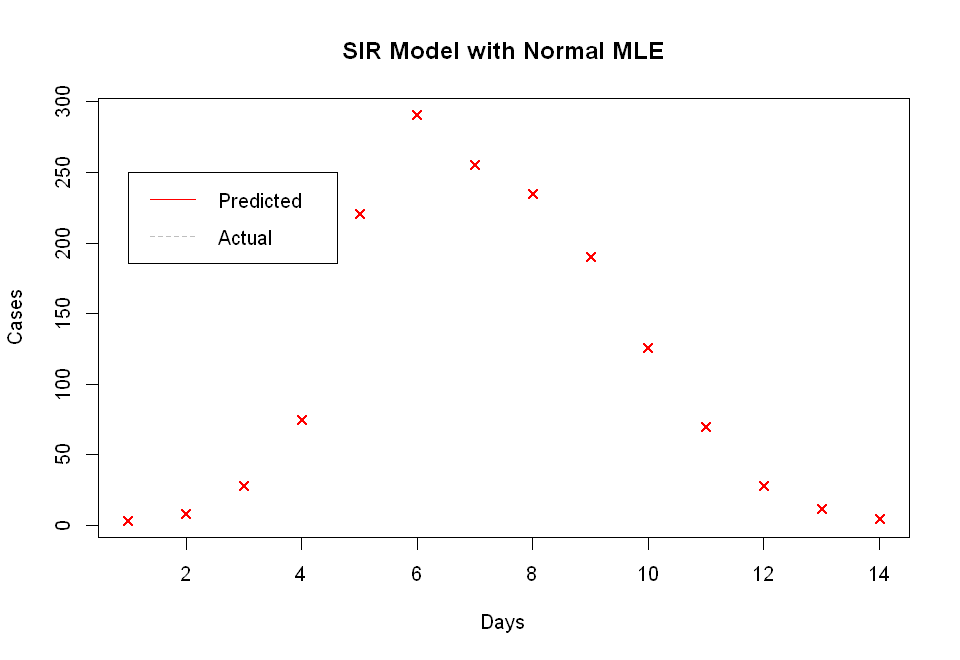

In [117]:
times <- seq(0,20,0.1)
normal_model <-c(as.double(initial_conditions['Y']), model(gamma=as.double(parameters['gamma']),
                       beta=as.double(parameters['beta']),
                       times = seq(0.1,20,0.1),
                       initial_conditions=initial_conditions)$Y)
compare_model(normal_model, "SIR Model with Normal MLE", times)

In [61]:
poissonLL <- function(gamma, beta){
    beta <- exp(beta)
    gamma <- exp(gamma)
    model_data <- model(beta = beta, gamma = gamma, times=df$days, initial_data=initial_conditions)
    -sum(dpois(x = df$cases[-1], lambda = model_data[-1], log = TRUE))
}
initial_params <- list(beta = 1.66, gamma = 1/2.2)
po_results <- mle2(minuslogl = poissonLL, start = lapply(initial_params, log),method = "Nelder-Mead")
po_parameters <- exp(coef(po_results))
po_parameters

gamma         beta 
1.848720e-19 1.762862e+03